In [130]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
# Bonus vector manipulation
import pandas as pd
import geopandas as gpd
from shapely import wkt
from datetime import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Sentinel-2 WOFS Product Creation**

### Config

Import required DC utils

In [131]:
import datacube
# DC utilities
#from utils_dcal.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils_dcal.data_cube_utilities.dc_water_classifier import wofs_classify
from utils_dcal.data_cube_utilities.import_export import export_xarray_to_netcdf

#SAC utilities
from sac_utils.clean_mask import landsat_qa_clean_mask
from sac_utils.interactive_maps import display_map

Define aoi via wkt polygon (could be subbed or shapefile)

In [89]:
#aoi_wkt = "POLYGON((178.12 -18.25,178.15 -18.25,178.15 -18.27,178.12 -18.27,178.12 -18.25))"
#aoi_wkt = "POLYGON((178.24905395508 -18.036804199219, 178.51547241212 -18.038177490235, 178.51547241212 -18.220825195313, 178.25454711915 -18.220825195313, 178.24905395508 -18.036804199219))"
aoi_wkt = "POLYGON((177.75226467901712 -17.879622210337537,177.80204647833352 -17.879622210337537,177.80204647833352 -17.914988456071715,177.75226467901712 -17.914988456071715,177.75226467901712 -17.879622210337537))"
#aoi_wkt = "POLYGON((178.11035156251 -17.841796875, 178.83544921876 -17.830810546875, 178.83544921876 -18.297729492187, 178.10485839844 -18.30322265625, 178.11035156251 -17.841796875))"
aoi = gpd.GeoDataFrame(pd.DataFrame({'geoms':[wkt.loads(aoi_wkt)]}), geometry='geoms')


In [90]:
dc = datacube.Datacube(app="na")

In [91]:
area_json = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.maxy.values[0]
            ],
            [
                aoi.bounds.maxx.values[0],
                aoi.bounds.maxy.values[0]
            ],
            [
                aoi.bounds.maxx.values[0],
                aoi.bounds.miny.values[0]
            ],
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.miny.values[0]
            ],
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.maxy.values[0]
            ]
          ]
        ]
      }
    }
  ]
}

In [92]:
lons, lats = zip(*area_json["features"][0]["geometry"]["coordinates"][0])
lat_extents = (min(lats), max(lats))
lon_extents = (min(lons), max(lons))
print("Lat:", lat_extents, "\n"
      "Lon:", lon_extents)

Lat: (-17.914988456071715, -17.879622210337537) 
Lon: (177.75226467901712, 177.80204647833352)


In [93]:
display_map(latitude = lat_extents, longitude = lon_extents)

### Load Data

Generic query specs

In [94]:
from datetime import datetime

query = dict(   latitude = lat_extents,
                longitude = lon_extents,
                output_crs = "EPSG:32760",
                time = (datetime(2019,1,16), datetime(2019,1,18)),
                resolution = (30,30))

Dataset-specifics

In [95]:
scenes = dc.load(product="s2_esa_sr_granule",
               #group_by='solar_day',
               measurements = ["green","red","blue","nir","swir1","swir2","coastal_aerosol","scene_classification"],
               **query)

In [96]:
#scenes['swir1']=scenes.swir_1
#scenes['swir2']=scenes.swir_2
#scenes = scenes.drop('swir_1')
#scenes = scenes.drop('swir_2')

In [97]:
scenes

<xarray.Dataset>
Dimensions:               (time: 1, x: 177, y: 132)
Coordinates:
  * time                  (time) datetime64[ns] 2019-01-17T22:30:11
  * y                     (y) float64 8.019e+06 8.019e+06 ... 8.023e+06
  * x                     (x) float64 5.797e+05 5.797e+05 ... 5.849e+05 5.85e+05
Data variables:
    green                 (time, y, x) uint16 426 453 410 547 ... 348 572 689
    red                   (time, y, x) uint16 164 170 161 221 ... 120 252 333
    blue                  (time, y, x) uint16 213 222 204 263 ... 164 265 318
    nir                   (time, y, x) uint16 4049 3735 3639 ... 2391 3539 3670
    swir1                 (time, y, x) uint16 1568 1449 1476 ... 1122 1757 1519
    swir2                 (time, y, x) uint16 599 555 582 954 ... 426 752 664
    coastal_aerosol       (time, y, x) uint16 269 269 326 326 ... 249 249 261
    scene_classification  (time, y, x) uint8 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4
Attributes:
    crs:      EPSG:32760

Check loaded

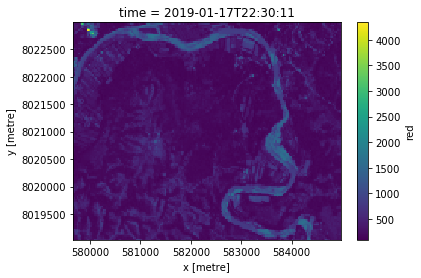

In [146]:
scenes.isel(time = 0).red.plot();

In [147]:
#baseline_composite = scenes.isel(time = 4).red.plot();
#from utils_dcal.data_cube_utilities.dc_rgb import rgb
#rgb(baseline_composite, x_coord='x', y_coord='y')

Create + apply 'cleansky' mask

8


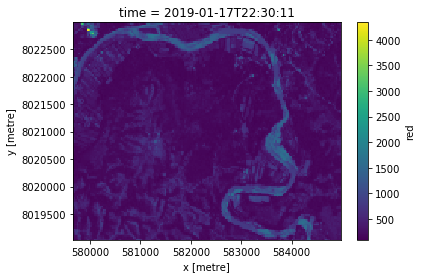

In [150]:
print(len(scenes))
###from sac_utils.clean_mask_delete import landsat_qa_clean_mask
clearsky_masks = landsat_qa_clean_mask(scenes, 'SENTINEL_2')
clearsky_scenes = scenes.where(clearsky_masks)
clearsky_scenes.isel(time = 0).red.plot();

Apply wofs classification

In [151]:
water_classes = wofs_classify(scenes, clean_mask=clearsky_masks.values, no_data = np.nan, x_coord='x', y_coord = "y")

Visualise wofs summary product

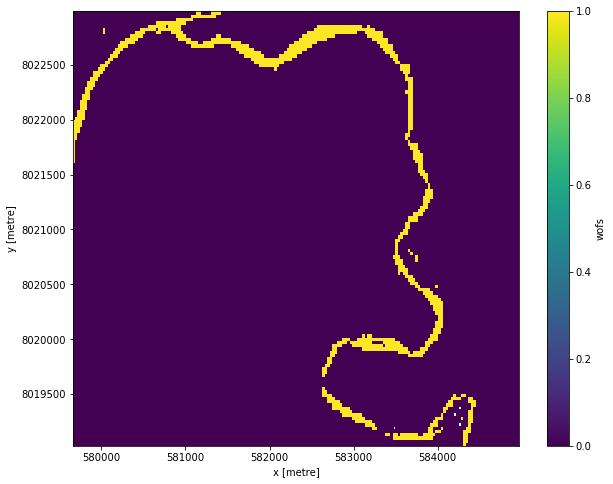

In [152]:
plt.figure(figsize = (10,8))
water_classes.wofs.mean(dim = 'time').plot()

### Export to File with Shared Storage

Define output path

In [16]:
# Ensure the output directory exists before writing to it.
!mkdir -p /home/shared/geo_demos/wofs_testers
output_file_name  =  "/home/shared/geo_demos/wofs_testers/s2_wofs_product_VL.nc"

In [17]:
scenes.attrs

OrderedDict([('crs', CRS('EPSG:32760'))])

In [18]:
dataset_to_output =  water_classes.assign_attrs(scenes.attrs)

In [19]:
dataset_to_output.attrs

OrderedDict([('crs', CRS('EPSG:32760'))])

In [20]:
export_xarray_to_netcdf(dataset_to_output, output_file_name)